In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2


import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import utils


In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

### Notes on data
ACCESS: 10 years of pi control on the co2pulse run; take G 10 years in

GFDL: pi control run for 100 years before pulse, co2pulse run starts at 100 years in without any picontrol data

UKESM1: 10 years of pi control on the co2pulse run; take G 10 years in

MIROC: co2pulse starts 10 years after pi control, but doesn't include that in its data

NORESM2: picontrol starts in 1851 and co2pulse starts in 1850, both should start in 1851 according to documentation

CanESM5 (p2): picontrol is at 5601, but was branched at 5301; co2pulse was branched at 5401;line up by moving picontrol dt to start at 5301

In [3]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_esm_picontrol_dict


In [4]:
A = utils.A
ds_out = utils.ds_out

In [18]:
ds_control = {}
ds_pulse = {}
G = {}

for m1 in model_run_pulse_dict.keys():
    if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
        m2 = 'CANESM5_r1p2'
    else:
        m2 = m1
    print(m2, m1)
    ds_control[m1], ds_pulse[m1], G[m1] = utils.import_regrid_calc(f'cmip6_data/tas_Amon_{model_run_control_dict[m2]}', 
                                                 f'cmip6_data/tas_Amon_{model_run_pulse_dict[m1]}', 
                                                 ds_out, variable = 'tas', m = m1, pulse_type = 'pulse', pulse_size = 100, replace_xy = True,
                                                        climatology = True)


UKESM1_r1 UKESM1_r1


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 60 times more chunks
  return self.array[key]


climatology run
MIROC MIROC


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 121 times more chunks
  return self.array[key]


climatology run
NORESM2 NORESM2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


climatology run
ACCESS ACCESS


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


climatology run
GFDL GFDL


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


climatology run
CANESM5_r1p2 CANESM5_r1p2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 200 times more chunks
  return self.array[key]


climatology run
CANESM5_r1p2 CANESM5_r2p2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 200 times more chunks
  return self.array[key]


climatology run
CANESM5_r1p2 CANESM5_r3p2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 200 times more chunks
  return self.array[key]


climatology run


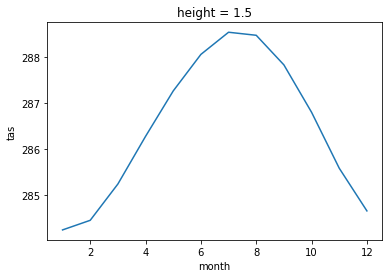

In [20]:
ds_control['UKESM1_r1']['tas'].weighted(A).mean(dim = ['lat','lon']).groupby('time.month').mean('time').plot()

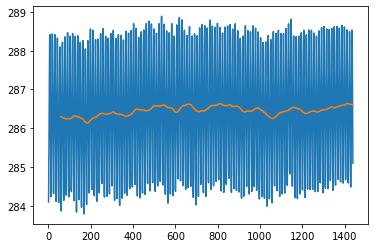

In [31]:
fig, ax = plt.subplots()
#fig, ax = plt.subplots()
plt.plot(ds_control['UKESM1_r1']['tas'].weighted(A).mean(dim = ['lat','lon']).rolling(time = 2).mean())
plt.plot(ds_control['UKESM1_r1']['tas'].weighted(A).mean(dim = ['lat','lon']).rolling(time = 5*12).mean())


In [6]:
for m in G.keys():
    G[m]['year'] = G[m]['year'] - G[m]['year'][0]

In [7]:
G_ds = xr.concat([G[m] for m in G.keys()], pd.Index([m for m in G.keys()], name='model'))


In [8]:
G_CANESM5_mean = G_ds.where(G_ds.model.isin(['CANESM5_r1p2','CANESM5_r2p2', 'CANESM5_r3p2']), drop = True).mean(dim = 'model')

In [9]:
G_mean_ds = xr.concat([G_CANESM5_mean, G_ds.sel(model = 'UKESM1_r1').drop(['model', 'height']), G_ds.sel(model = 'MIROC').drop(['model', 'height']), 
           G_ds.sel(model = 'NORESM2').drop(['model', 'height']), G_ds.sel(model = 'ACCESS').drop(['model', 'height']), G_ds.sel(model = 'GFDL').drop(['model', 'height'])], 
          pd.Index(['CANESM5_mean', 'UKESM1_r1', 'MIROC', 'NORESM2', 'ACCESS', 'GFDL'], name='model'))

In [10]:
G_mean_ds = G_mean_ds.mean(dim = 'model')

## Save Green's Functions

In [11]:
G_ds.to_netcdf('Outputs/G_ds_climatology.nc4')
#G_mean_ds.to_netcdf('Outputs/G_mean_ds.nc4')
